In [5]:

import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [26]:
# from 
# https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html
def applyWaterShed(img):
    
    #img = cv2.imread(fileName)
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # maybe needed if image is read with opencv
    #print(img.shape)
    imgG = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(imgG,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)


    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(img,markers)
    img[markers == -1] = [0,255,0]
    
    return img,markers

In [47]:
# sample images and code from
# https://www.kaggle.com/fanconic/starter-skin-cancer-malignant-vs-benign

folder_benign_train = './archive/train/benign'
folder_malignant_train = './archive/train/malignant'

folder_benign_test = './archive/test/benign'
folder_malignant_test = './archive/test/malignant'


read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]



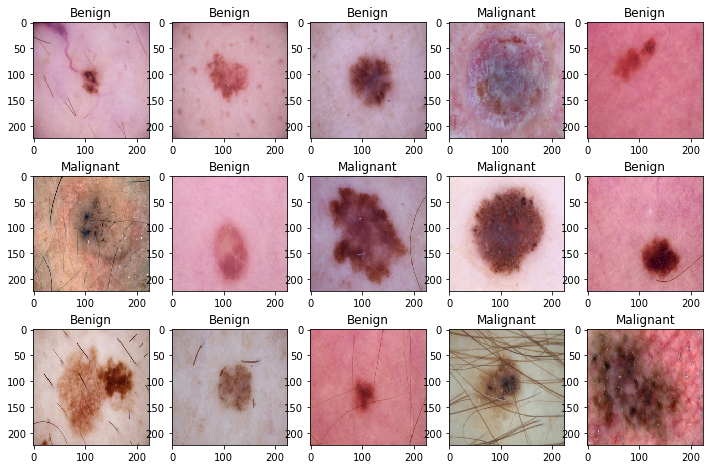

In [12]:

w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
#plt.show()

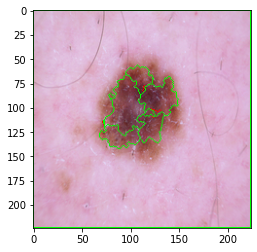

In [41]:
# test watershed segmentation on 1 image
img = X_train[0]
img,markers = applyWaterShed(img)
plt.imshow(img)

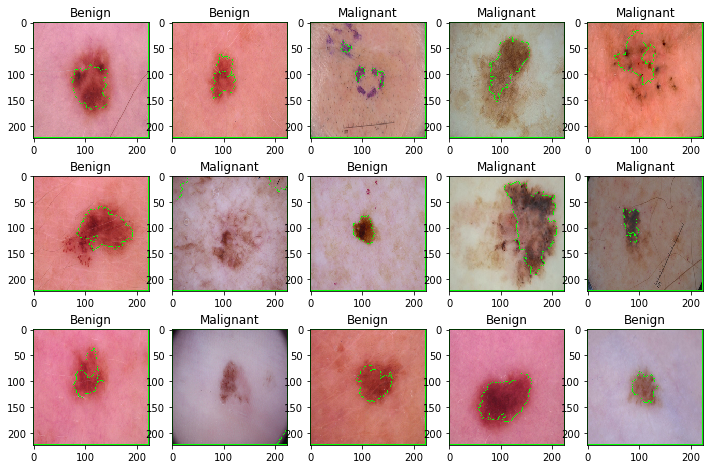

In [48]:
# Test segmentation on previous sample images and show contour of segmented region 
# The watershed segmentation seems to outline the area of interest correctly, but 
# doewsn't always work
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    img = X_train[i]
    img,markers = applyWaterShed(img)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(img, interpolation='nearest')

In [50]:
# Following code from
# https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html
def getBoundingBoxes(img):
  
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


    im2, contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(contours.shape)
    finalC = []
    for c in im2:
        if len(c)>200 and len(c) < 450: # filter out contours too big or small
            finalC.append(c)
        
    #print(contours[0])
    contours_poly = [None]*len(finalC)
    boundRect = [None]*len(finalC)
    for i, c in enumerate(finalC):
        #print(i)
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
        cv2.rectangle(img, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (0,0,255), 2)

    return img,boundRect


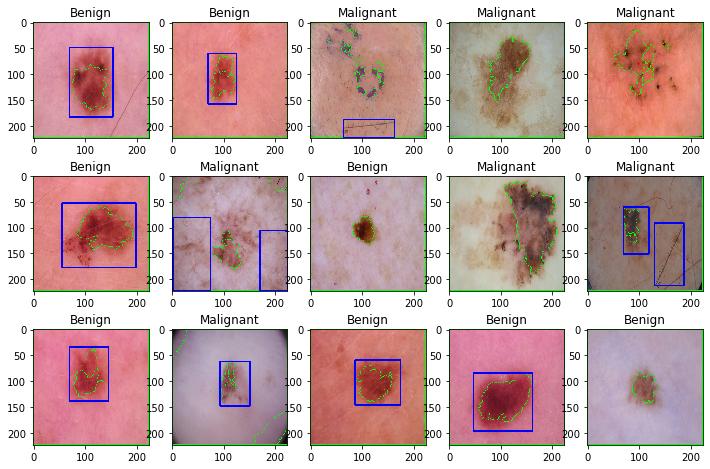

In [51]:
# A bounding box can be found for the segmented image. 
# It works well in some cases but additional processing is needed

w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    img = X_train[i]
    img,markers = applyWaterShed(img)
    img,rectBoxes = getBoundingBoxes(img)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(img, interpolation='nearest')